## 2.2 Para los modelos estudiados en el punto 2.1, presente el entrenamiento y evaluación de los mismos sobre la base de datos Fashion Mnist. Discuta los resultados obtenidos y los tips de entrenamiento utilizados en cada caso para facilitar la convergencia de cada uno de los métodos.

In [66]:
import numpy as np  # Arrays y operaciones matemáticas.
import sklearn  # Algoritmos de aprendizaje automático.
import tensorflow as tf  # Construcción y entrenamiento de modelos de aprendizaje profundo.
from tensorflow import keras  # API de alto nivel para redes neuronales.
import matplotlib.pyplot as plt  # Visualización de datos y gráficos.

In [67]:
# Cargar los datos de Fashion MNIST.
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Convertir los datos a tipo float32 y normalizarlos dividiendo por 255.
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Dividir los datos de entrenamiento en un conjunto de entrenamiento y un conjunto de validación.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


In [68]:

#history.history.keys() #Me entrega diccionario

In [69]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Aplicación de Max Norm Constraint
MaxNormDense = keras.layers.Dense

def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(20, activation='relu')(x)
    z_mean = MaxNormDense(latent_dim)(x)
    z_log_var = MaxNormDense(latent_dim)(x)  # Reparametrización datos
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Dropout(0.5)(x)  # Aplicación de Dropout
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):  # Acá se hace la reparametrización de los datos
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):  # Reparametrización
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Parámetros del modelo
latent_dim = 128  # Dimensión del espacio latente al que se va a reducir los datos
encoder = build_encoder(latent_dim)  # Construir el modelo encoder con la dimensión latente especificada
decoder = build_decoder(latent_dim)  # Construir el modelo decoder con la misma dimensión latente
vae = VAE(encoder, decoder)  # Crear una instancia del modelo VAE combinando el encoder y el decoder

# Compilar el modelo VAE
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=[rounded_accuracy])

# Configuración de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = vae.fit(X_train, X_train, epochs=25, batch_size=64, validation_data=(X_valid, X_valid), callbacks=[early_stopping])

# Funciones para mostrar imágenes
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


Epoch 1/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.4821 - rounded_accuracy: 0.7724 - val_loss: 0.4297 - val_rounded_accuracy: 0.8352
Epoch 2/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4206 - rounded_accuracy: 0.8374 - val_loss: 0.4175 - val_rounded_accuracy: 0.8426
Epoch 3/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4111 - rounded_accuracy: 0.8492 - val_loss: 0.4002 - val_rounded_accuracy: 0.8583
Epoch 4/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3940 - rounded_accuracy: 0.8614 - val_loss: 0.3879 - val_rounded_accuracy: 0.8675
Epoch 5/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3847 - rounded_accuracy: 0.8686 - val_loss: 0.3826 - val_rounded_accuracy: 0.8711
Epoch 6/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3786 - rounded_accuracy: 0.8729 - val_loss: 0.3775 - val_rounded_accuracy: 0.8788
Epoch 7/25
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3752 - rounded_accuracy: 0.8765 - val_loss: 0.3762 - val_rounded_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


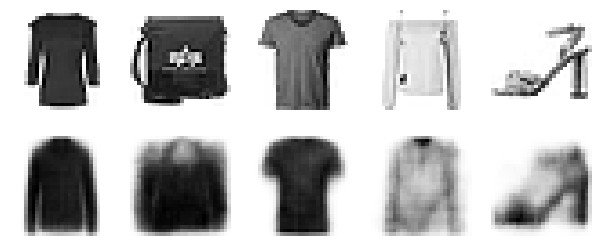

In [70]:
# Función para graficar y mostrar las reconstrucciones
def plot_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Imágenes originales
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].reshape(28, 28), cmap="binary")
        plt.axis("off")
        # Imágenes reconstruidas
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index].reshape(28, 28), cmap="binary")
        plt.axis("off")
    plt.show()

# Usar la función con tu modelo y datos
plot_reconstructions(vae, X_valid, n_images=5)


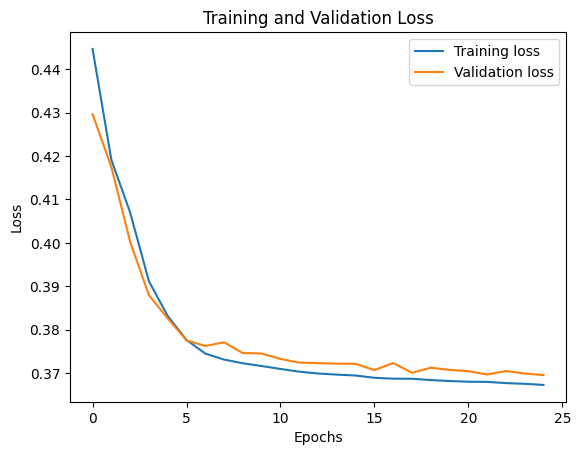

In [71]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

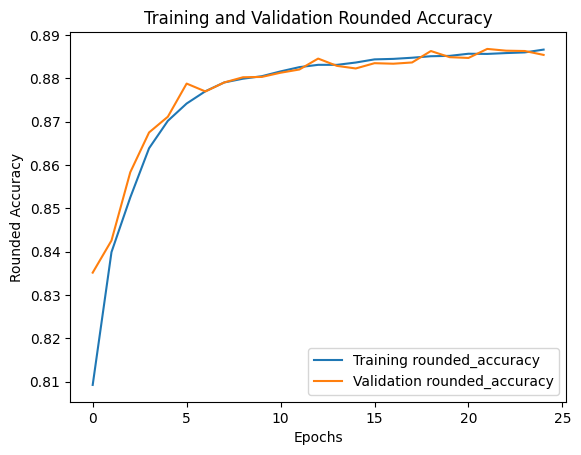

In [72]:
plt.plot(history.history['rounded_accuracy'], label='Training rounded_accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation rounded_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Rounded Accuracy')
plt.title('Training and Validation Rounded Accuracy')
plt.legend()
plt.show()


loss: La pérdida (loss) calculada en el conjunto de entrenamiento al final de cada época.

rounded_accuracy: La precisión (accuracy) calculada en el conjunto de entrenamiento usando la métrica personalizada rounded_accuracy, que compara las etiquetas verdaderas y las predicciones después de redondearlas.

val_loss: La pérdida (loss) calculada en el conjunto de validación al final de cada época.

val_rounded_accuracy: La precisión (accuracy) calculada en el conjunto de validación usando la métrica rounded_accuracy, aplicada a las predicciones y etiquetas de validación.